# Futures active contracts
This notebook checks traded volume for each contract month to see which month is actively traded. Some instruments do list monthly contracts but not all of them have the same trading activity. This information is useful to determine the default rolling schedule.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import signal
from vivace.backtest.contract import all_futures_baltas2020
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy

In [2]:
all_futures_baltas2020['name'].values

array(['WTI Crude Oil', 'Brent Crude Oil', 'Heating Oil', 'Natural Gas',
       'Gasoline', 'Copper', 'Gold', 'Palladium', 'Platinum', 'Silver',
       'Feeder Cattle', 'Live Cattle', 'Lean Hog', 'Corn', 'Oats',
       'Soybean Oil', 'Soybean Meal', 'Soybean', 'Wheat', 'Cocoa',
       'Coffee', 'Cotton', 'Lumber', 'Orange Juice', 'Sugar',
       'Australian Dollar', 'Canadian Dollar', 'Swiss Franc', 'Euro',
       'British Pound', 'Japanese Yen', 'E-Mini Nasdaq 100',
       'E-mini S&P 500', 'E-mini Russell 2000', 'FTSE 100', 'DAX',
       'CAC 40', 'IBEX 35', 'AEX', 'Swiss Market Index', 'SPI 200',
       'Topix', 'Hang Seng', 'US 2-year Treasury', 'US 5-year Treasury',
       'US 10-year Treasury', 'US treasury Bond', 'Germany Schatz',
       'Germany Bobl', 'Germany Bund', 'Germany Buxl', 'Gilt',
       'Canada 10-year Treasury', 'JGB'], dtype=object)

Calculate the average of trade volume over the 5 days before its roll date. Then take the ratio of each contract month relative to the annual average to see which contract month is more actively traded.

In [3]:
volume_summary = []

for instrument, row in tqdm(all_futures_baltas2020.iterrows(), leave=False, desc='instrument'):
    # calculate long-only 
    engine = BacktestEngine(
        start_date=datetime(2018, 1, 1),
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        log_level=logging.WARNING,
    )
    engine.run()
    
    # calculate traded volume ratio for each conract month
    volume = pd.DataFrame([(i.contract_month, i.data.loc[:i.roll_date, 'volume'].tail(5).mean()) 
                           for i in engine.contracts],
                          columns=['contract_month', 'volume'])
    volume = volume.groupby('contract_month').mean().squeeze()
    volume /= volume.sum()
    volume = volume.to_frame(row['name']).T  
    volume['asset_class'] = row['asset_class']
    volume_summary.append(volume)
#     break
    
volume_summary = pd.concat(volume_summary)

In [4]:
def plot_heatmap(volume_summary: pd.DataFrame, asset_class: str, figsize):
    """ Plot the volume summary as a heatmap """
    fig, ax = plt.subplots(figsize=figsize)
    (volume_summary.query(f'asset_class == "{asset_class}"').drop('asset_class', axis=1)
     .pipe(sns.heatmap, ax=ax, cmap='RdBu', center=0, annot=True, cbar=False, fmt='.0%'));
    ax.set_title(asset_class)
    ax.set_ylabel('Contract month')

## Commodity

- Energy contracts have monthly contracts and most of them are evenly traded.
- Precious metals also have monthly contracts, but only the selected set of months seems to be traded
- For other contracts, all listed months are traded with a few exceptions in lean hogs and cotton.

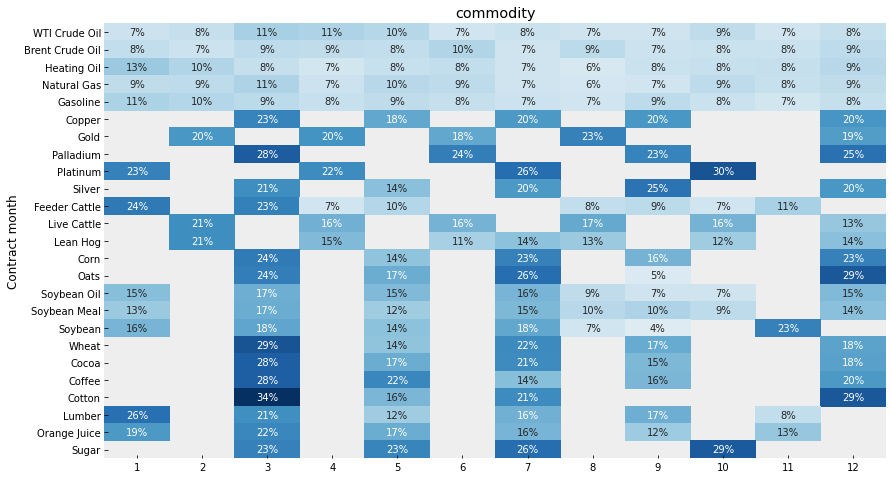

In [5]:
plot_heatmap(volume_summary, 'commodity', (14, 8))

## FX
- Only quarterlies are traded.

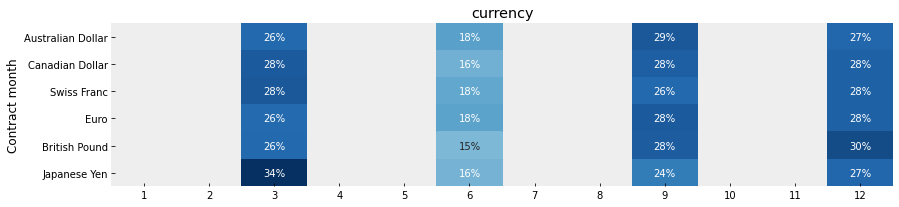

In [6]:
plot_heatmap(volume_summary, 'currency', (14, 3))

## Equity
- Similar to FX, quarterlies are mainly traded. Some counties also have monthly contracts which are evenly traded except Australia (SPI 200 Index)

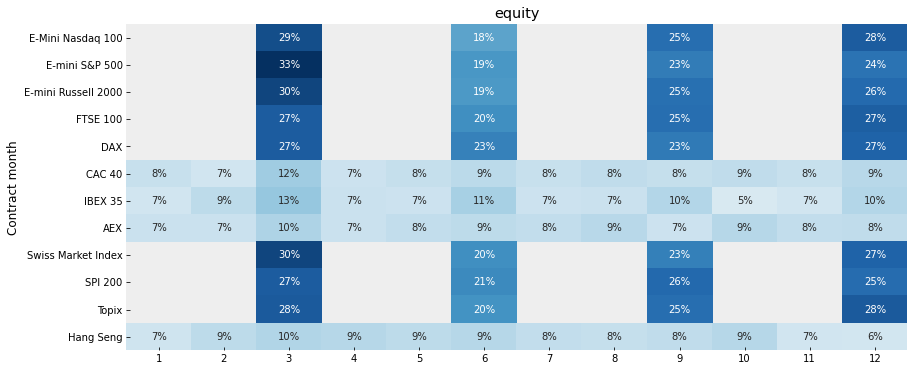

In [7]:
plot_heatmap(volume_summary, 'equity', (14, 6))

## Government bond
- Only quarterlies are available and they are evenly traded.

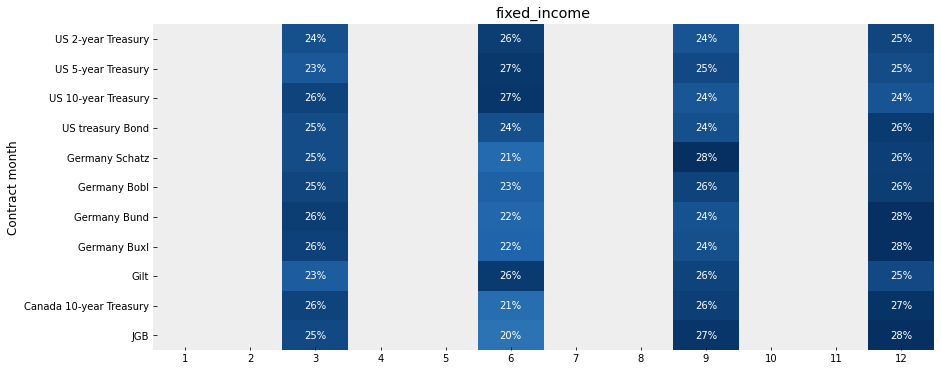

In [8]:
plot_heatmap(volume_summary, 'fixed_income', (14, 6))